# Check Activity and Networking of a specific Github-Account

In [1]:
import pyprind
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [2]:
person = 'llSourcell'

In [3]:
url = 'https://github.com'

data = []
for year in range(2010, 2019):
    html = requests.get('{}/{}?tab=overview&from={}-12-01&to={}-12-31'.format(url, person, year, year)).text
    bs = BeautifulSoup(html, 'lxml')
    for rect in bs.find('div', {'class':'js-calendar-graph is-graph-loading graph-canvas calendar-graph height-full'}).findAll('rect'):
        data.append([rect['data-date'], int(rect['data-count'])])

In [4]:
df = pd.DataFrame(data, columns=['Date', 'Contributions'])
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.loc[df[df['Contributions']>0].index[0]:df[df['Contributions']>0].index[-1]]

dict_weekday = {i:day for i, day in enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])}
df['Weekday'] = [dict_weekday[x] for x in df.index.weekday]

print('Shape: {}'.format(df.shape))

Shape: (2343, 2)


In [5]:
df.head()

,Contributions,Weekday
Date,,
2011-12-22,1,Thursday
2011-12-23,0,Friday
2011-12-24,0,Saturday
2011-12-25,0,Sunday
2011-12-26,0,Monday


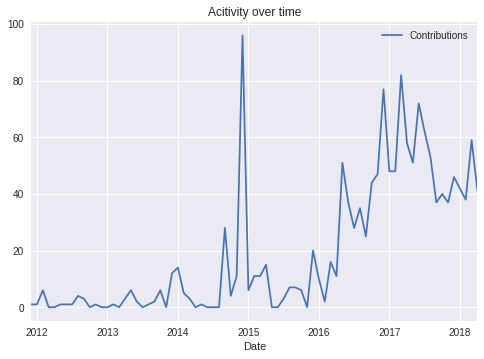

In [6]:
df.groupby(pd.TimeGrouper('m', closed='left')).sum().plot(title='Acitivity over time')
plt.show()

In [7]:
_, week_order = zip(*dict_weekday.items())

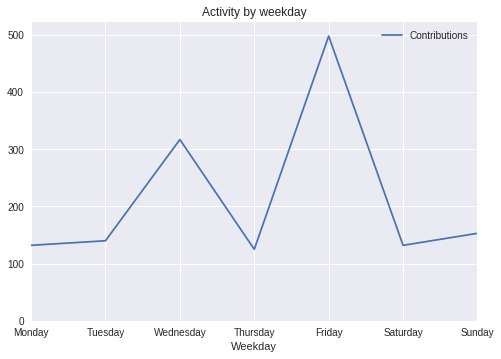

In [8]:
df_plot = df.groupby('Weekday').sum().reindex(index=week_order)
df_plot.plot(title='Activity by weekday')
plt.ylim(0, df_plot.max().values[0]*1.05)
plt.show()

# Download followers and create a network graph

In [9]:
def getPeople(person, task='following'):
    if task!='following':
        task = 'followers'
    i = 1
    while True:
        html = requests.get('{}/{}?page={}&tab={}'.format(url, person, i, task)).text
        bs = BeautifulSoup(html, 'lxml')

        for following in bs.findAll('div', {'class':'d-table-cell col-9 v-align-top pr-3'}):
            pers_alias = person
            name = following.find('span', {'class':'f4 link-gray-dark'}).get_text()
            account = following.find('span', {'class':'link-gray pl-1'}).get_text()
            place = None
            organisation = None
            try:
                box = following.find('p', {'class':'text-gray text-small mb-0'})
                if box.find('svg', {'class':'octicon octicon-location'}):
                    place = box.get_text().strip().split('\n')[-1]
                try: organisation = box.find('span', {'class':'mr-3'}).get_text().strip()
                except: pass
            except: pass

            if task=='followers':
                account, pers_alias = pers_alias, account
            followers.append([account, pers_alias, name, place, organisation, task])

        if bs.find('div', {'class':'pagination'}):
            i += 1
        else: break

In [10]:
followers = []

getPeople(person, task='following')
getPeople(person, task='followers')
df = pd.DataFrame(followers, columns=['Source', 'Target', 'Name', 'Location', 'Organisation', 'Task'])

In [11]:
people = df[['Source', 'Target']].stack().unique()
bar = pyprind.ProgPercent(len(people))
for follower in people:
    if follower!=person:
        getPeople(follower, task='following')
        getPeople(follower, task='followers')
    bar.update()

[100 %] Time elapsed: 00:52:20 | ETA: 00:00:00
Total time elapsed: 00:52:20


In [12]:
df = pd.DataFrame(followers, columns=['Source', 'Target', 'Name', 'Location', 'Organisation', 'Task'])
df.to_csv('build/Graph_Network_{}.csv'.format(person), index=False)
print(df.shape)
df.head()

(52613, 6)


,Source,Target,Name,Location,Organisation,Task
0,adambcomer,llSourcell,Adam Comer,"Toronto, Ontario",University of Toronto,following
1,bogo,llSourcell,Bogo Giertler,"San Francisco, CA",Dropbox,following
2,wbison,llSourcell,wbison,None,None,following
3,sonya,llSourcell,sonya huang,"Cambridge, MA","Modo Labs, Inc.",following
4,llSourcell,AbhijeetPendyala,AbhijeetPendyala,None,None,followers


In [13]:
df = pd.read_csv('build/Graph_Network_{}.csv'.format(person))

In [14]:
df.head()

,Source,Target,Name,Location,Organisation,Task
0,adambcomer,llSourcell,Adam Comer,"Toronto, Ontario",University of Toronto,following
1,bogo,llSourcell,Bogo Giertler,"San Francisco, CA",Dropbox,following
2,wbison,llSourcell,wbison,NaN,NaN,following
3,sonya,llSourcell,sonya huang,"Cambridge, MA","Modo Labs, Inc.",following
4,llSourcell,AbhijeetPendyala,AbhijeetPendyala,NaN,NaN,followers


In [15]:
df_network = df[df['Task']=='following'].groupby('Source').agg({'Name':'max', 'Location':'max', 'Organisation':'max'}).reset_index()

In [16]:
def titleWords(x):
    return x.replace('@', '').title().split(',')[0].strip()

In [17]:
df_network['Location'] = df_network['Location'].apply(lambda x: titleWords(x) if pd.notnull(x) else x)
df_network['Organisation'] = df_network['Organisation'].apply(lambda x: titleWords(x) if pd.notnull(x) else x)

In [18]:
df_network.head()

,Source,Name,Location,Organisation
0,007jedgar,Jonathan Edgar,Tx,Pixe Human Connections
1,00ec454,Dharmesh Gohil,San Francisco,NaN
2,01773370085,Rahim badsha,Rahim,Rahim
3,01Comandos,Comandos,Venezuela,NaN
4,01sadra,Sadra Aliabadi,NaN,NaN


# Organisations and Locations of the followers

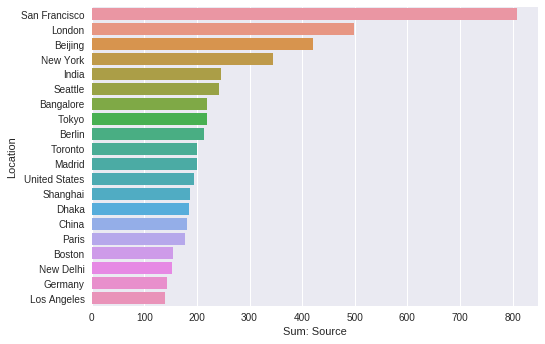

In [19]:
n = 20
bar = 'Location'
value = 'Source'
sns.barplot(y=bar, x=value, data=df_network.groupby(bar).agg({value:'count'}).sort_values(value, ascending=False).reset_index().head(n))
plt.xlabel('Sum: {}'.format(value))
plt.show()

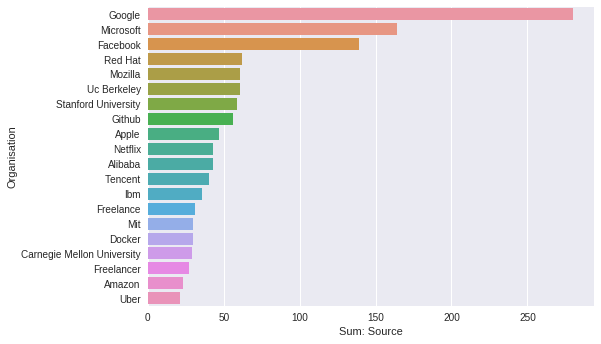

In [20]:
n = 20
bar = 'Organisation'
value = 'Source'
sns.barplot(y=bar, x=value, data=df_network.groupby(bar).agg({value:'count'}).sort_values(value, ascending=False).reset_index().head(n))
plt.xlabel('Sum: {}'.format(value))
plt.show()

In [21]:
n = 10
s = df_network.groupby(['Location', 'Organisation'])['Source'].count()>1
df_loc_org = df_network.groupby(['Location', 'Organisation'])['Source'].count()[s].reset_index().sort_values('Source', ascending=False)
df_loc_org.head(n)

,Location,Organisation,Source
340,Mountain View,Google,46
469,San Francisco,Google,36
84,Berkeley,Uc Berkeley,34
562,Stanford,Stanford University,29
526,Seattle,Microsoft,25
431,Redmond,Microsoft,25
216,Hangzhou,Alibaba,22
411,Pittsburgh,Carnegie Mellon University,21
283,London,Facebook,21
331,Menlo Park,Facebook,19


# Find locations of big companies

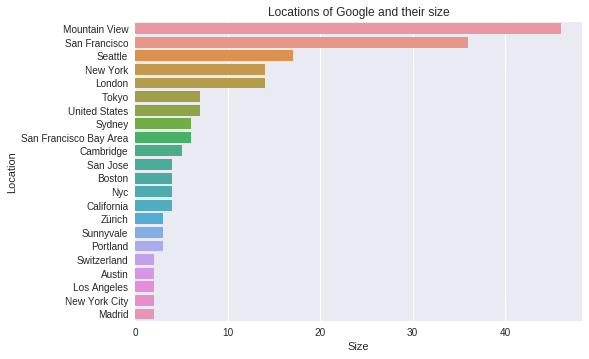

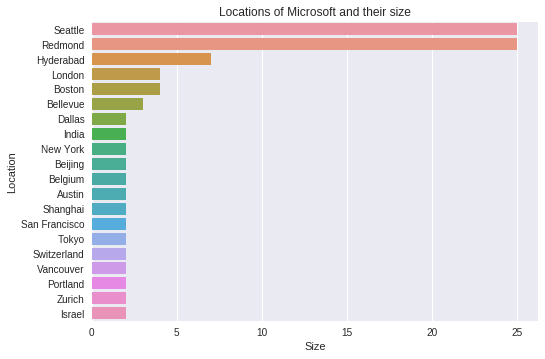

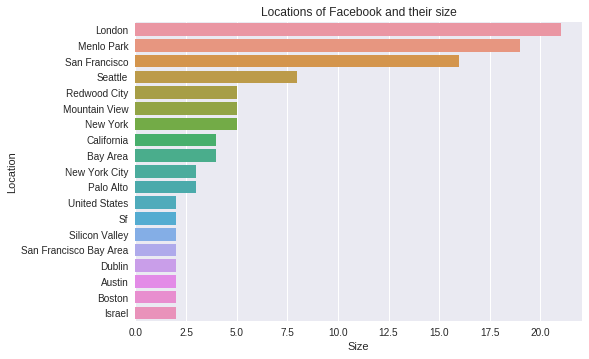

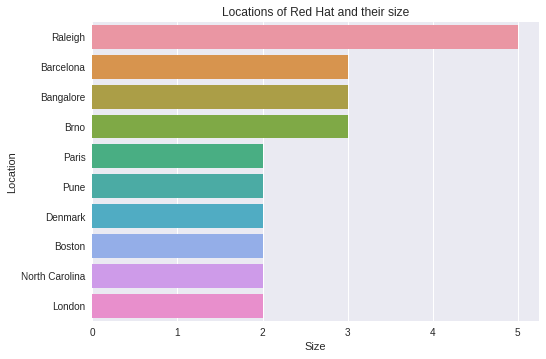

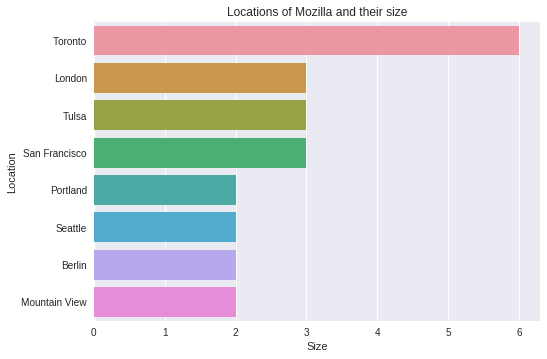

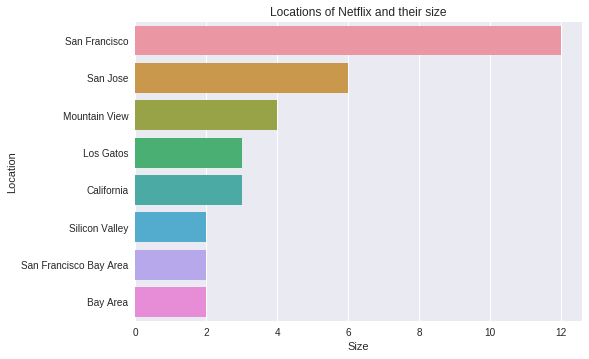

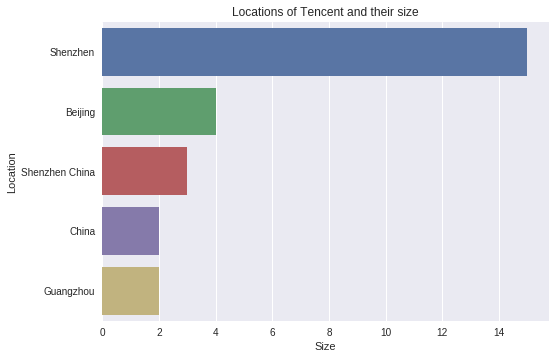

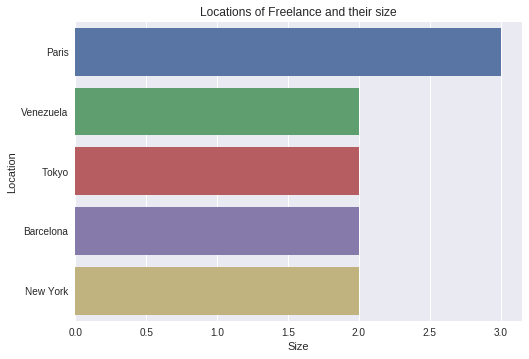

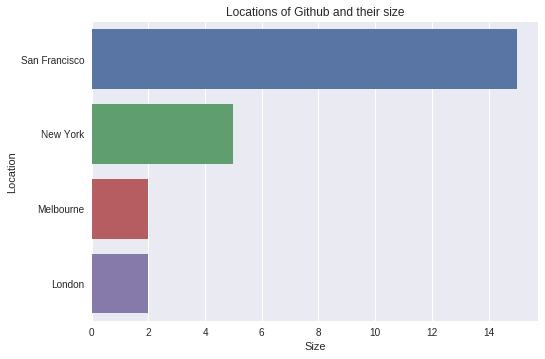

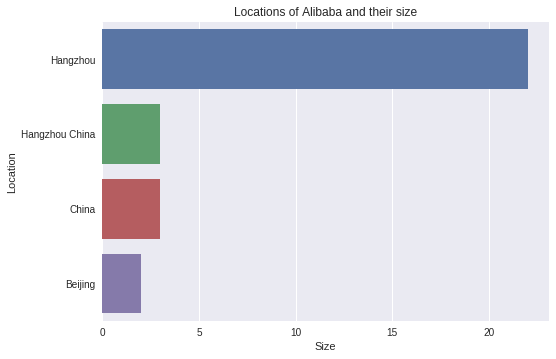

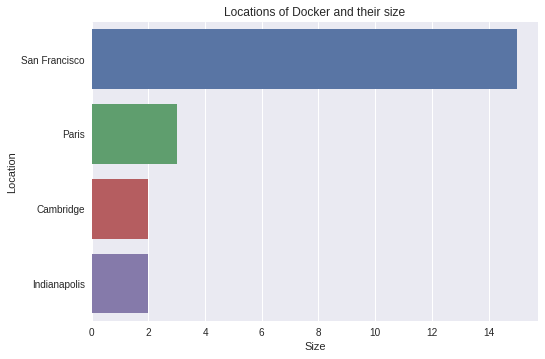

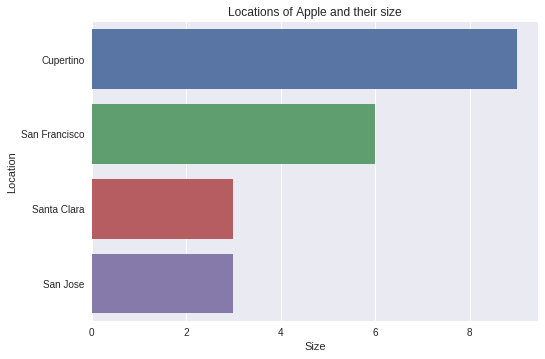

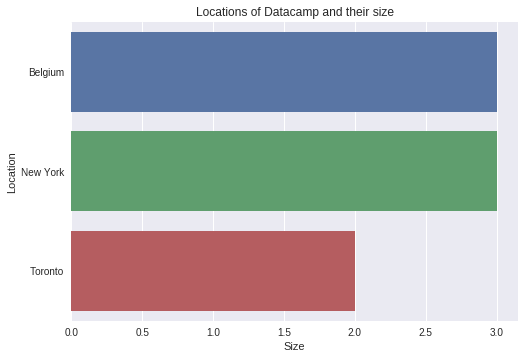

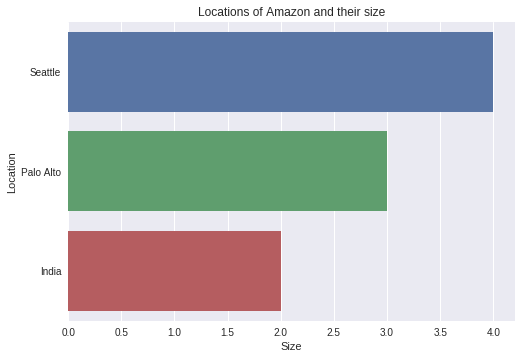

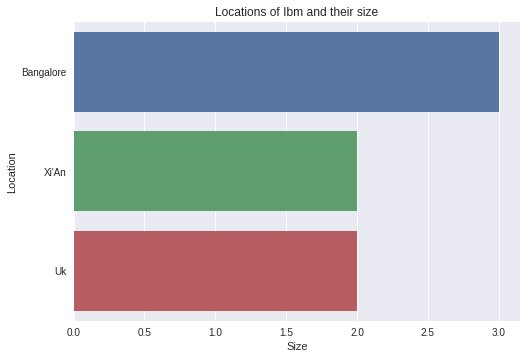

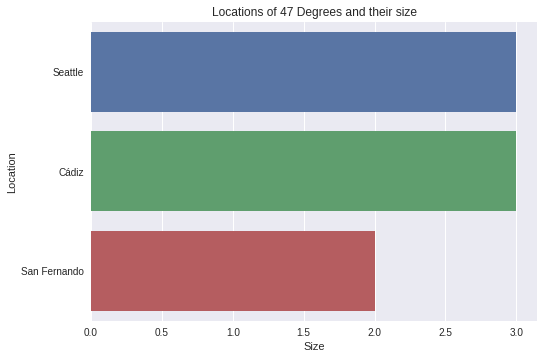

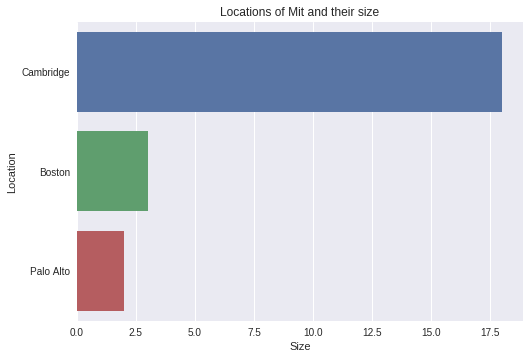

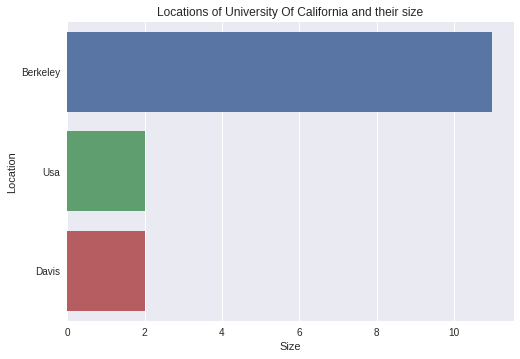

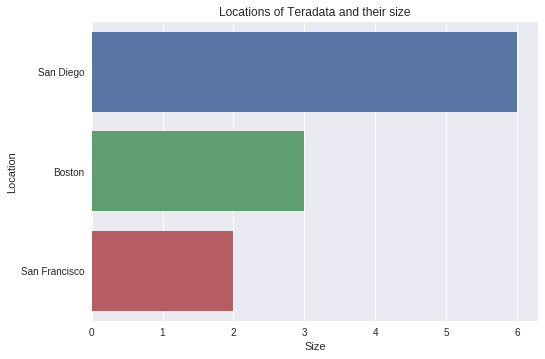

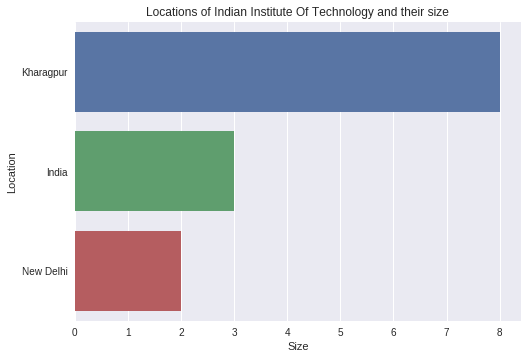

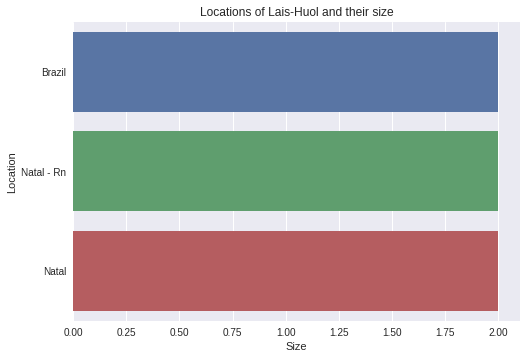

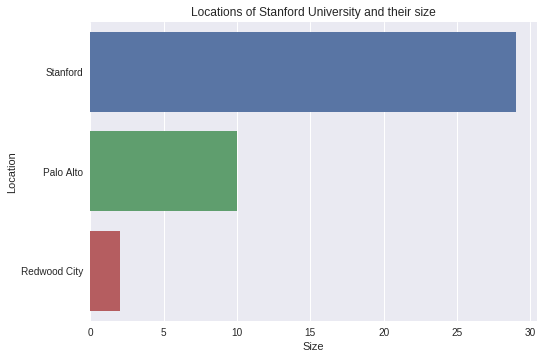

In [22]:
s = df_loc_org['Organisation'].value_counts()>2
index_list = df_loc_org['Organisation'].value_counts()[s].index

for org in index_list:
    df_plot = df_loc_org[df_loc_org['Organisation']==org].sort_values('Source', ascending=False)
    sns.barplot(x='Source', y='Location', data=df_plot)
    plt.title('Locations of {} and their size'.format(org))
    plt.xlabel('Size')
    plt.show()